# Machine-Learning

### Recommendations: Linear Reg, DTRegression, NeuralNetwork, SVM, LogisticReg

### Multi Variable Regression (TBC)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split # Random Split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [3]:
df = pd.read_csv('data/clean_listing.csv')
df.head()

,Unnamed: 0,index,host_response_rate,latitude,longitude,accommodates,bedrooms,beds,price,availability_365,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_since_years,distance_from_MRT,distance_from_Bus,distance_from_Mall,distance_from_School,distance_from_Food
0,0,1,0.9,1.34754,103.95958,1,1.0,1.0,81.0,242,...,0,0,1,0,12,0.842953,0.180102,7.976199,3.515767,0.785094
1,1,2,0.9,1.34531,103.96100,2,1.0,2.0,81.0,305,...,0,0,1,0,12,0.880282,0.205346,7.952045,3.786036,0.502588
2,2,3,1.0,1.29015,103.80814,1,1.0,1.0,52.0,273,...,0,0,1,0,12,0.549557,0.117975,4.230675,1.095807,0.169376
3,3,4,1.0,1.28836,103.81144,1,1.0,1.0,49.0,281,...,0,0,1,0,12,0.609339,0.040906,3.862544,0.685090,0.208523
4,4,5,0.9,1.34490,103.95979,4,3.0,5.0,175.0,242,...,0,0,1,0,12,0.738518,0.210803,7.816646,3.809634,0.506811


In [4]:
#Split data
Y = df['price']
X = df.iloc[:,4:]

In [5]:
X.head()

,longitude,accommodates,bedrooms,beds,price,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_since_years,distance_from_MRT,distance_from_Bus,distance_from_Mall,distance_from_School,distance_from_Food
0,103.95958,1,1.0,1.0,81.0,242,24,4.16,4.22,4.09,...,0,0,1,0,12,0.842953,0.180102,7.976199,3.515767,0.785094
1,103.96100,2,1.0,2.0,81.0,305,47,4.41,4.39,4.52,...,0,0,1,0,12,0.880282,0.205346,7.952045,3.786036,0.502588
2,103.80814,1,1.0,1.0,52.0,273,22,4.40,4.16,4.26,...,0,0,1,0,12,0.549557,0.117975,4.230675,1.095807,0.169376
3,103.81144,1,1.0,1.0,49.0,281,14,4.50,4.69,4.23,...,0,0,1,0,12,0.609339,0.040906,3.862544,0.685090,0.208523
4,103.95979,4,3.0,5.0,175.0,242,12,4.83,4.67,4.75,...,0,0,1,0,12,0.738518,0.210803,7.816646,3.809634,0.506811


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=45)

In [14]:
reg = LinearRegression()
reg.fit(X_train, y_train)

y_train_pred = reg.predict(X_train)
y_pred = reg.predict(X_test)

r2_score(y_test, y_pred)

1.0

In [8]:
def mean_sq_err(actual, predicted):
    '''Returns the Mean Squared Error of actual and predicted values'''
    return np.mean(np.square(np.array(actual) - np.array(predicted)))


mse = mean_sq_err(y_test, y_pred)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))

Mean Squared Error (MSE) 	: 1.2753541260757105e-26
Root Mean Squared Error (RMSE) 	: 1.129315777838825e-13


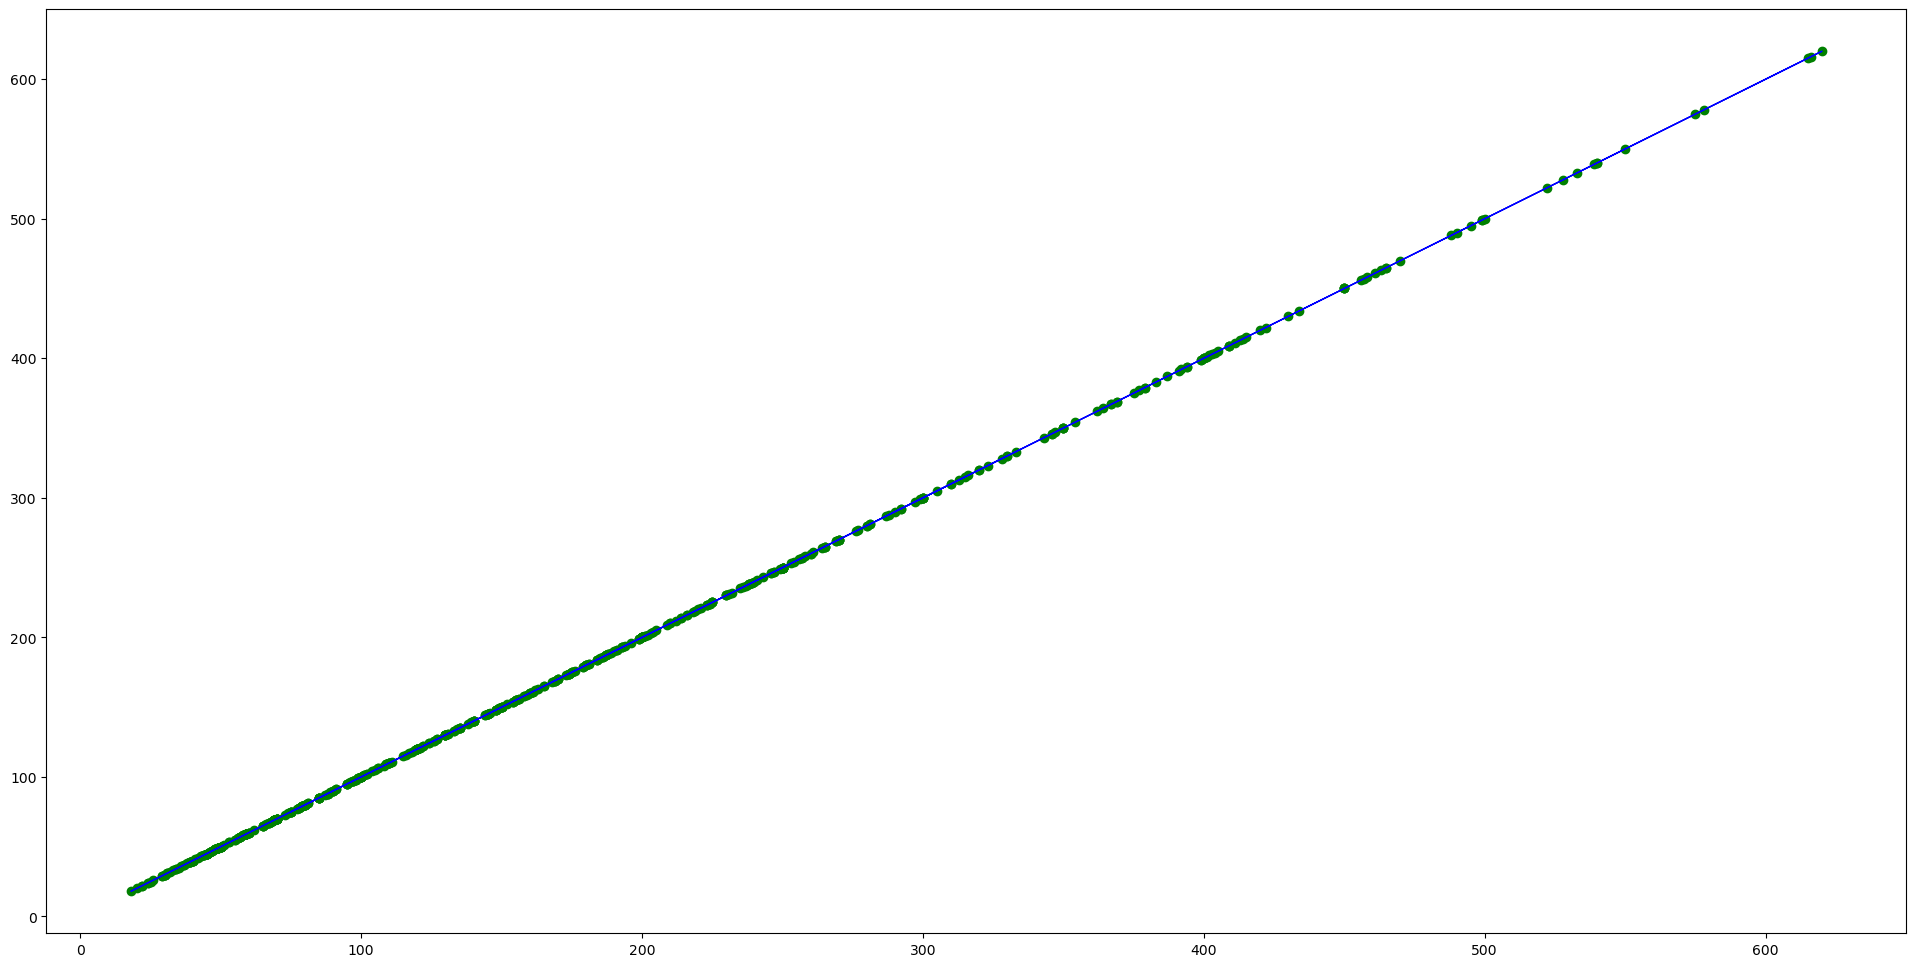

In [9]:
f, axes = plt.subplots(1,1, figsize=(24,12))    

    
axes.scatter(y_test,y_pred,color = "green")
axes.plot(y_test, y_test, 'b-', linewidth = 1)

In [13]:
from sklearn.svm import SVR
regressor=SVR(kernel='rbf')
regressor.fit(X_train, y_train)
predictions=regressor.predict(X_test)

r2_score(y_test, predictions)

0.9403432682521808

In [15]:
mse = mean_sq_err(y_test, predictions)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))

Mean Squared Error (MSE) 	: 1001.6483061320849
Root Mean Squared Error (RMSE) 	: 31.648827879276745


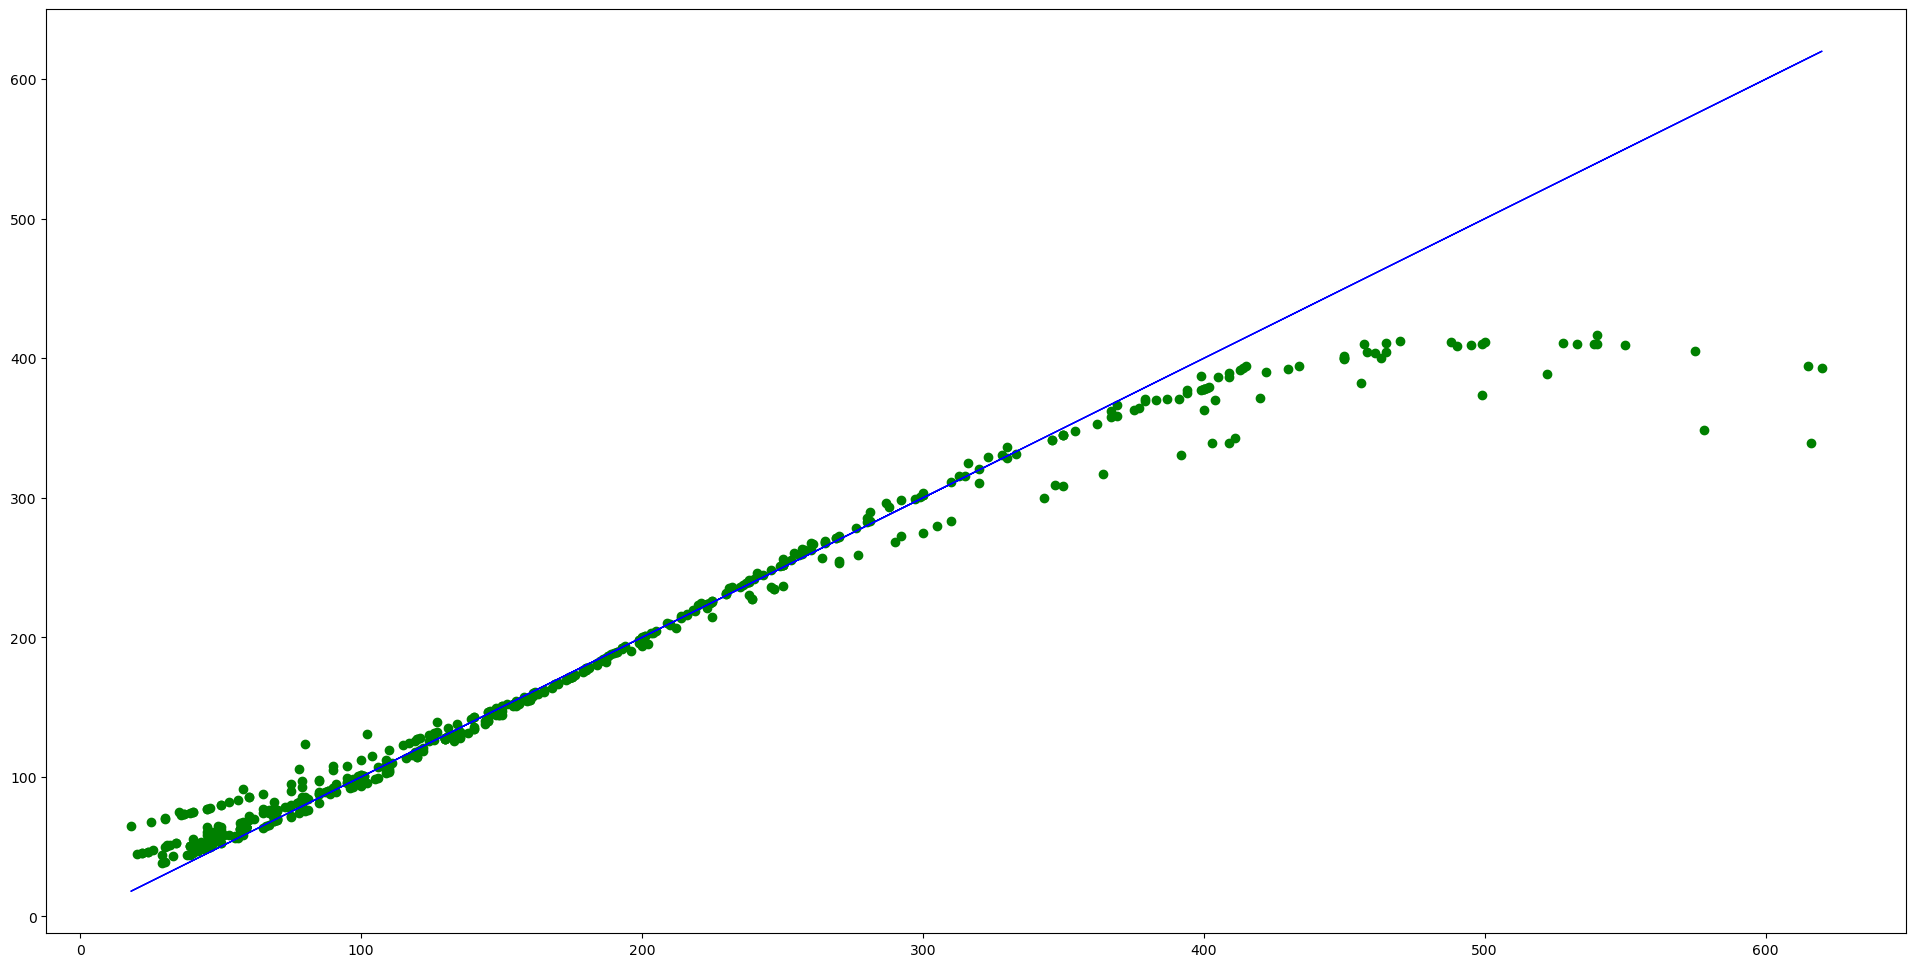

In [16]:
f, axes = plt.subplots(1,1, figsize=(24,12))    

    
axes.scatter(y_test,predictions,color = "green")
axes.plot(y_test, y_test, 'b-', linewidth = 1)